# Experiment ACRIM1 and HF

In [1]:
import datetime
import os

import gpflow as gpf
import numpy as np
import pandas as pd
import scipy.signal
import tensorflow as tf

from tsipy.fusion import LocalGPModel, SVGPModel
from tsipy.fusion.kernels import MultiWhiteKernel
from tsipy.fusion.utils import (
    build_and_concat_label_mask,
    build_and_concat_label_mask_output,
)
from tsipy.utils import (
    plot_signals,
    plot_signals_and_confidence,
    pprint,
    sort_inputs,
    transform_time_to_unit,
)

## Parameters

In [2]:
# Widths in years
pred_window_width = 1.0
fit_window_width = 3.0

normalization = True
clipping = True

num_inducing_pts = 500
max_iter = 5000

## Helpers

In [3]:
def load_dataset(dataset_name: str) -> pd.DataFrame:
    data_ = pd.read_csv(
        os.path.join("../data", f"{dataset_name}.txt"),
        delimiter=" ",
        header=None,
    )
    data_ = data_.rename(
        columns={
            0: "t",
            1: "a",
            2: "b",
        }
    )

    data_["t_org"] = data_["t"].values.copy()
    data_["t"] = transform_time_to_unit(
        data_["t"] - data_["t"][0],
        t_label="year",
        start=datetime.datetime(1980, 1, 1),
    )
    
    result_ = pd.read_csv(
        os.path.join("../data", f"{dataset_name}_results.txt"),
        delimiter=",",
        header=None,
    )
    result_ = result_.rename(
        columns={
            0: "t_org",
            1: "t",
            2: "s_out_mean",
            3: "s_out_std",
        }
    )
    return data_, result_

## Load dataset

Input Signal                                      
    - t_a                                         (3436,)
    - a                                           (3436,)
Input Signal                                      
    - t_b                                         (3436,)
    - b                                           (3436,)
Result Signal                                     
    - res_t                                       (3436,)
    - res_s_mean                                  (3436,)
    - res_s_std                                   (3436,)


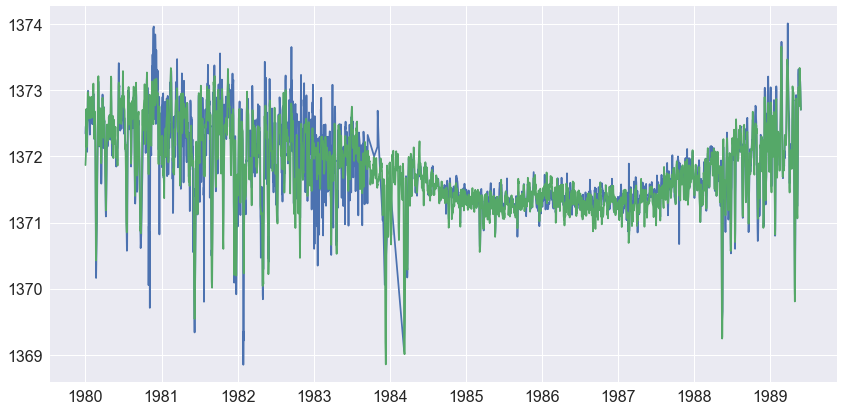

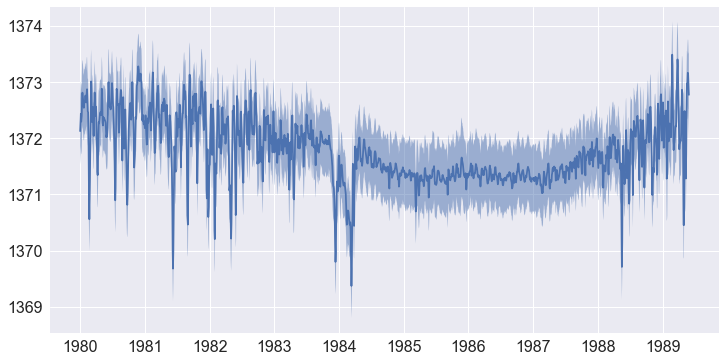

In [4]:
data, result = load_dataset("acrim1_hf")
t_a = t_b = data["t"].values
a = data["a"].values
b = data["b"].values

res_t = result["t"].values
res_s_mean = result["s_out_mean"].values
res_s_std = result["s_out_std"].values

pprint("Input Signal", level=0)
pprint("- t_a", t_a.shape, level=1)
pprint("- a", a.shape, level=1)

pprint("Input Signal", level=0)
pprint("- t_b", t_b.shape, level=1)
pprint("- b", b.shape, level=1)

pprint("Result Signal", level=0)
pprint("- res_t", t_b.shape, level=1)
pprint("- res_s_mean", res_s_mean.shape, level=1)
pprint("- res_s_std", res_s_std.shape, level=1)

_ = plot_signals(
    [
        (t_a, a, r"$a$", {}),
        (t_b, b, r"$b$", {}),
    ],
    x_ticker=1,
)

_ = plot_signals_and_confidence(
    [(res_t, res_s_mean, res_s_std, "SVGP")], x_ticker=1,
)

## Data Fusion

In [5]:
t_a = build_and_concat_label_mask(t_a, label=1)
t_b = build_and_concat_label_mask(t_b, label=2)
t_out = build_and_concat_label_mask_output(t_a)

t = np.vstack((t_a, t_b))
s = np.reshape(np.hstack((a, b)), newshape=(-1, 1))
t, s = sort_inputs(t, s, sort_axis=0)

pprint("Training data", level=0)
pprint("- t", t.shape, level=1)
pprint("- s", s.shape, level=1)

Training data                                     
    - t                                           (6872, 2)
    - s                                           (6872, 1)


### Kernel and Fusion Model

In [6]:
# Kernel
matern_kernel = gpf.kernels.Matern12(active_dims=[0])
white_kernel = MultiWhiteKernel(labels=(1, 2), active_dims=[1])  # Sensors 1 and 2
kernel = matern_kernel + white_kernel

# Fusion and local model
local_model = SVGPModel(
    kernel=kernel,
    num_inducing_pts=num_inducing_pts,
)
fusion_model = LocalGPModel(
    model=local_model,
    pred_window_width=pred_window_width,
    fit_window_width=fit_window_width,
    normalization=normalization,
    clipping=clipping,
)

### Training and Inference

In [7]:
# Train
fusion_model.fit(t, s, max_iter=max_iter, verbose=True)

# Predict
s_out_mean, s_out_std = fusion_model(t_out)

pprint("Output Signal", level=0)
pprint("- t_out", t_out.shape, level=1)
pprint("- s_out_mean", s_out_mean.shape, level=1)
pprint("- s_out_std", s_out_std.shape, level=1)

Window
    - Prediction:                                 -inf, 1981.000
    - Training:                                   1980.000, 1982.000
    - Data indices:                               0,     1461
    - x, y:                                       (1462, 2), (1462, 1)
    - n_ind_pts/time_unit                         167.000

    - Step      1/5000:                           -3235.966
    - Step   1000/5000:                           -1810.995
    - Step   2000/5000:                           -1325.180
    - Step   3000/5000:                           -1177.642
    - Step   4000/5000:                           -1300.299
    - Step   5000/5000:                           -1375.613
Window
    - Prediction:                                 1981.000, 1982.000
    - Training:                                   1980.000, 1983.000
    - Data indices:                               0,     2192
    - x, y:                                       (2193, 2), (2193, 1)
    - n_ind_pts/time_unit    

## Results

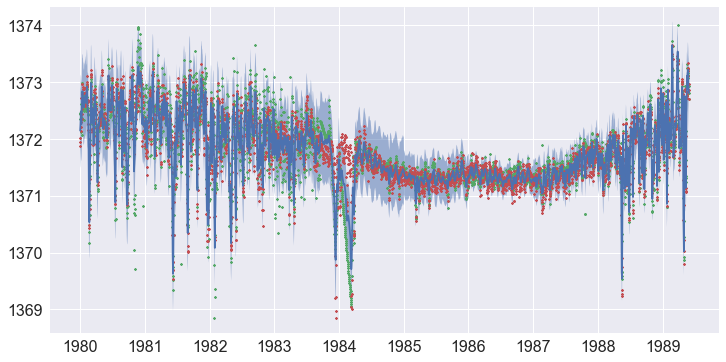

In [8]:
fig, ax = plot_signals_and_confidence(
    [(t_out[:, 0], s_out_mean, s_out_std, "LocalGP")], x_ticker=1,
)
ax.scatter(
    t_a[:, 0],
    a,
    label=r"$a$",
    s=3,
)
ax.scatter(
    t_b[:, 0],
    b,
    label=r"$b$",
    s=3,
)

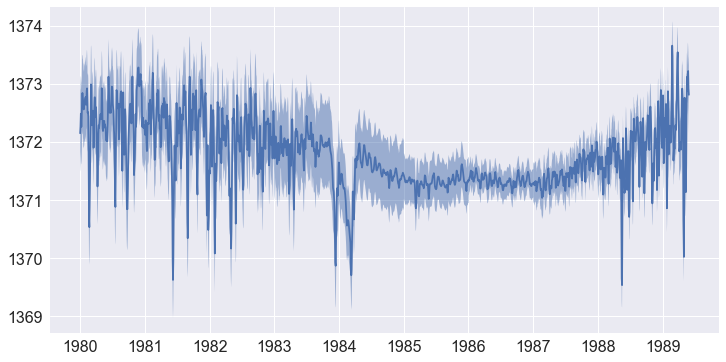

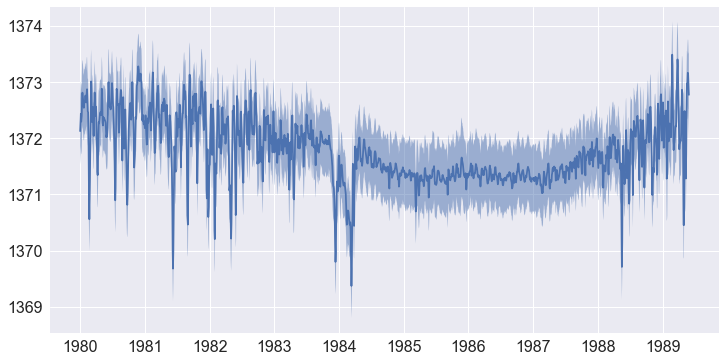

In [9]:
_ = plot_signals_and_confidence(
    [(t_out[:, 0], s_out_mean, s_out_std, "LocalGP")], x_ticker=1,
)

_ = plot_signals_and_confidence(
    [(res_t, res_s_mean, res_s_std, "SVGP")], x_ticker=1,
)

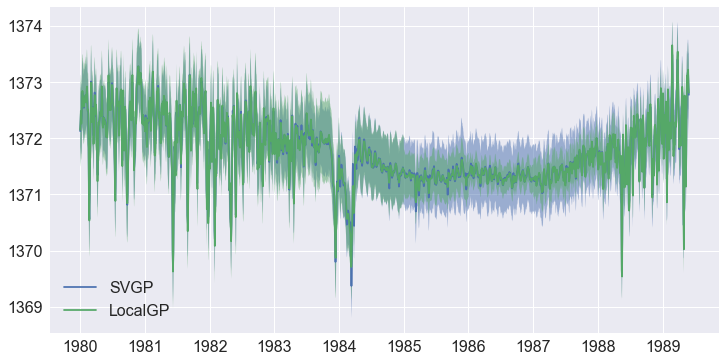

In [10]:
_ = plot_signals_and_confidence(
    [
        (res_t, res_s_mean, res_s_std, "SVGP"),
        (t_out[:, 0], s_out_mean, s_out_std, "LocalGP"),
    ],
    legend="lower left",
    x_ticker=1,
)

### Training

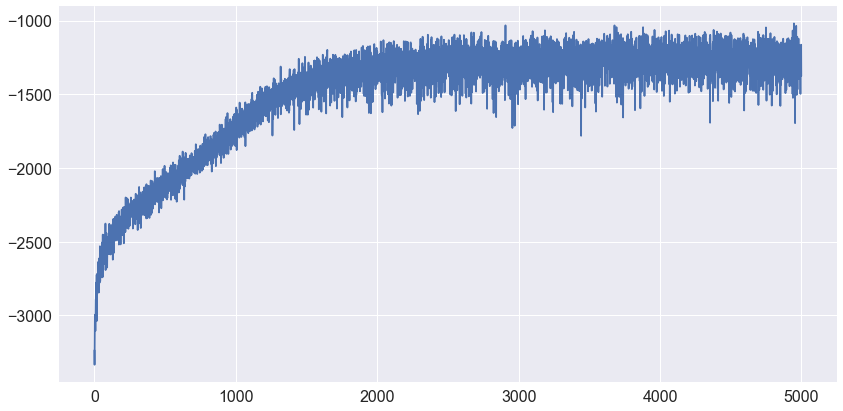

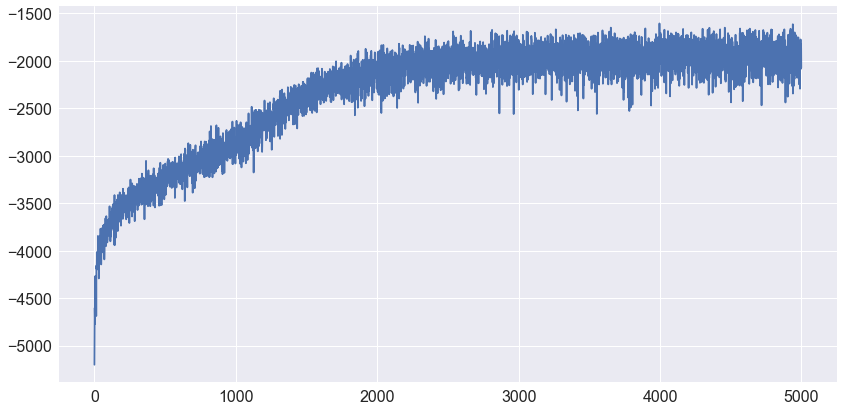

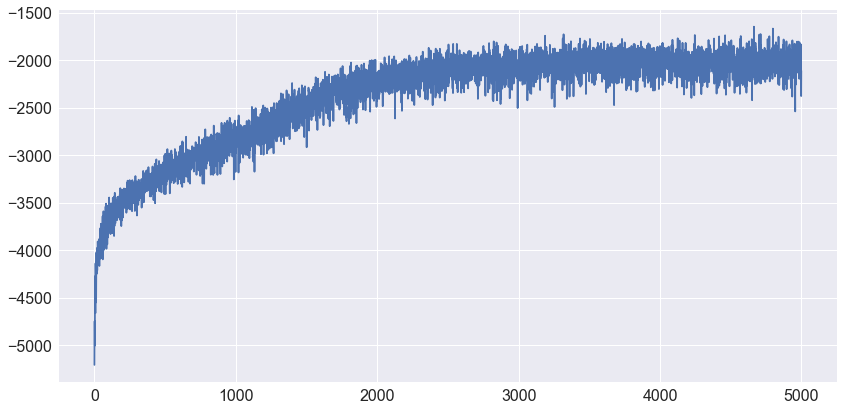

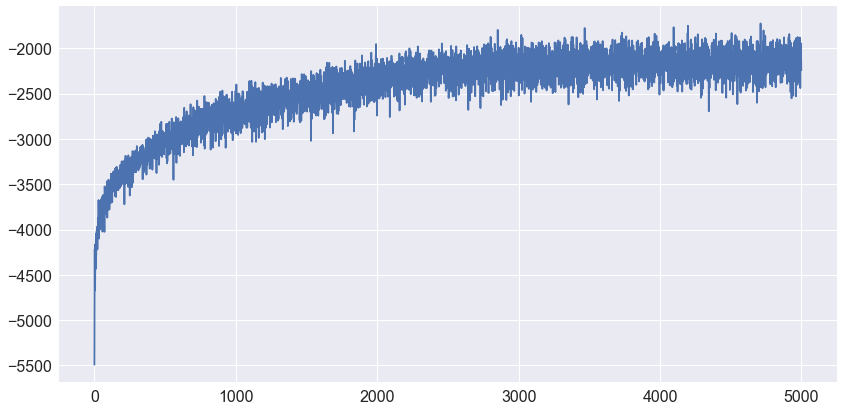

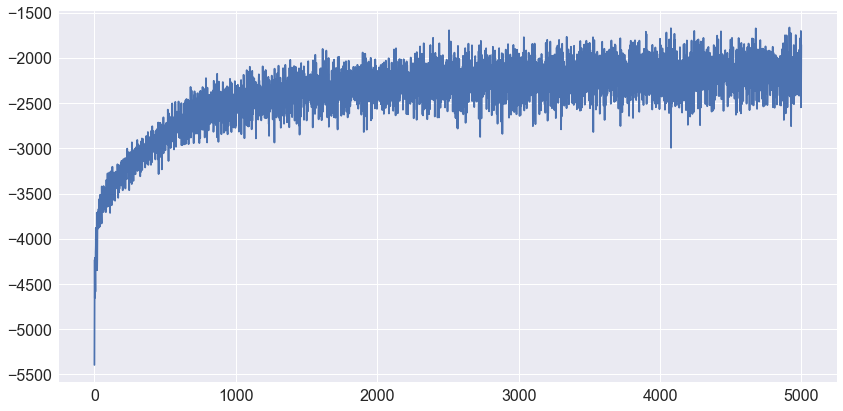

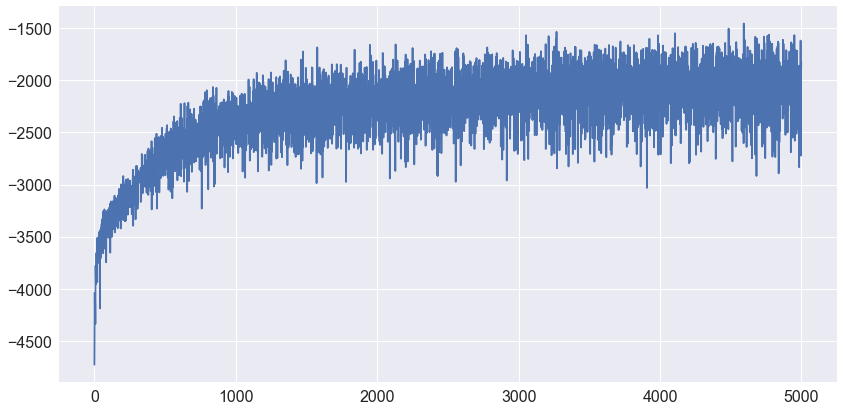

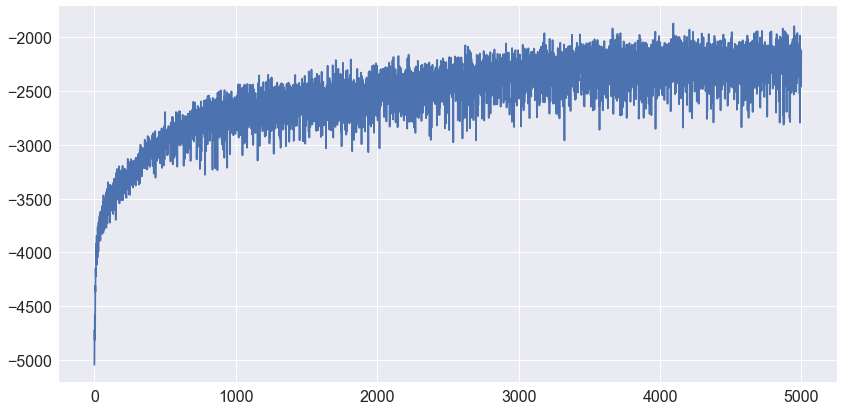

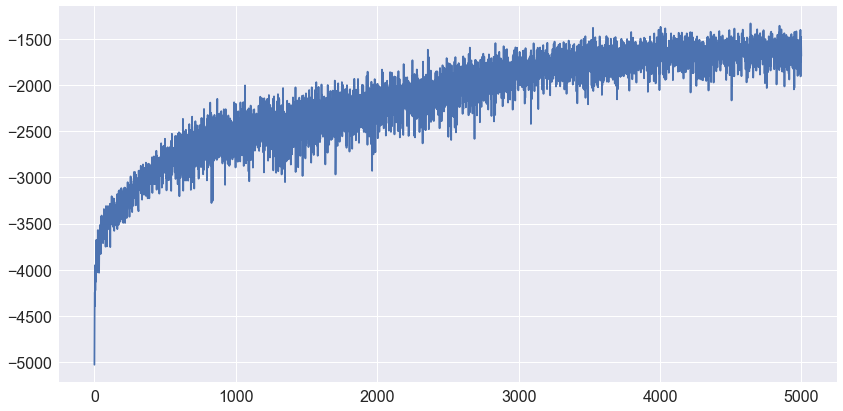

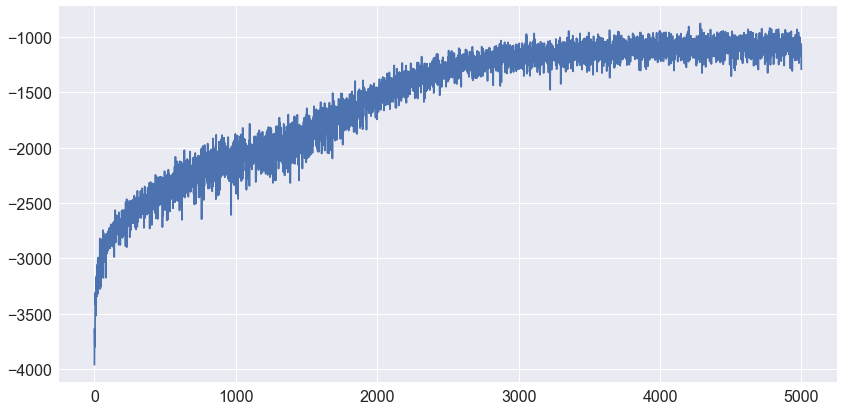

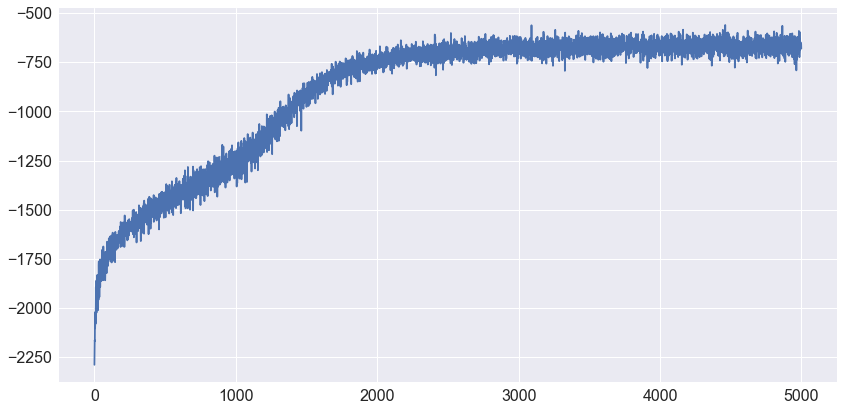

In [11]:
for i, window in enumerate(fusion_model.windows):
    elbo = window.model.iter_elbo
    plot_signals([(np.arange(elbo.size), elbo, r"ELBO", {})])

### Frequency Analysis

(<Figure size 864x432 with 1 Axes>, <AxesSubplot:>)

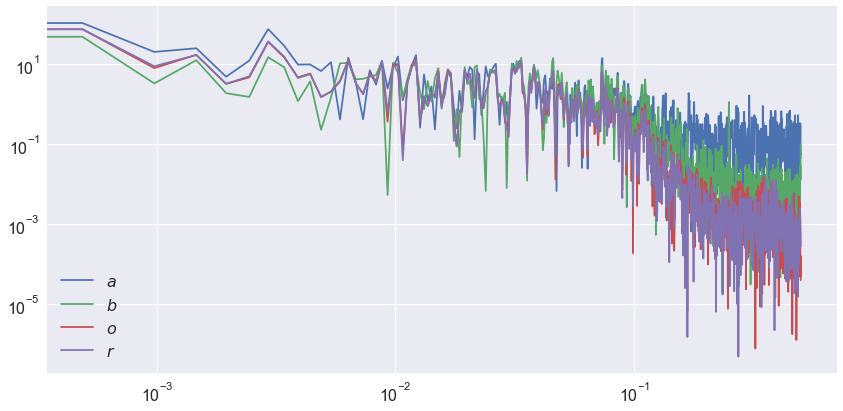

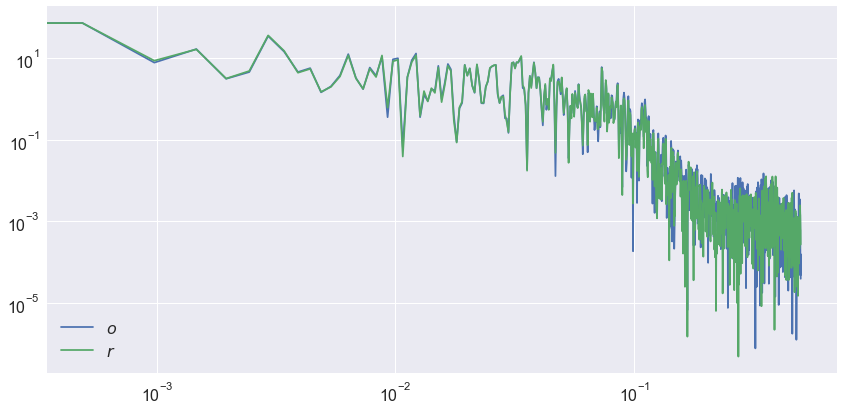

In [14]:
nn = 2
nperseg = 1024 * nn
noverlap = np.floor(nperseg * 0.15)
fs = 1.0  # Sampling frequency in days

freqs_a, psd_a = scipy.signal.welch(a, fs=fs, nperseg=nperseg, noverlap=noverlap)
freqs_b, psd_b = scipy.signal.welch(b, fs=fs, nperseg=nperseg, noverlap=noverlap)
freqs_out, psd_out = scipy.signal.welch(s_out_mean, fs=fs, nperseg=nperseg, noverlap=noverlap)
freqs_res, psd_res = scipy.signal.welch(res_s_mean, fs=fs, nperseg=nperseg, noverlap=noverlap)

plot_signals(
    [
        (freqs_a, psd_a, "$a$", {}),
        (freqs_b, psd_b, "$b$", {}),
        (freqs_out, psd_out, "$o$", {}),
        (freqs_res, psd_res, "$r$", {}),
    ],
    legend="lower left",
    log_scale_y=True,
    log_scale_x=True,
)

plot_signals(
    [
        (freqs_out, psd_out, "$o$", {}),
        (freqs_res, psd_res, "$r$", {}),
    ],
    legend="lower left",
    log_scale_y=True,
    log_scale_x=True,
)